In [1]:
###SVM model

Fitting 10 folds for each of 18 candidates, totalling 180 fits


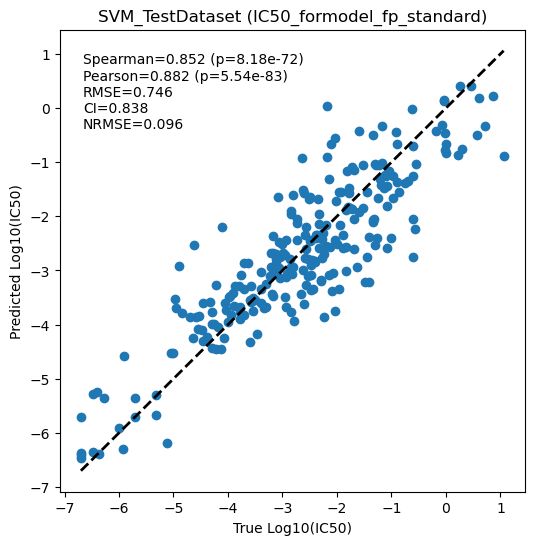

Fitting 10 folds for each of 18 candidates, totalling 180 fits


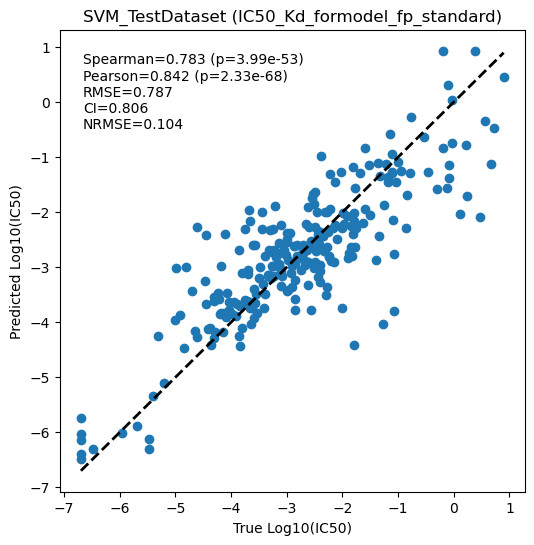

Fitting 10 folds for each of 18 candidates, totalling 180 fits


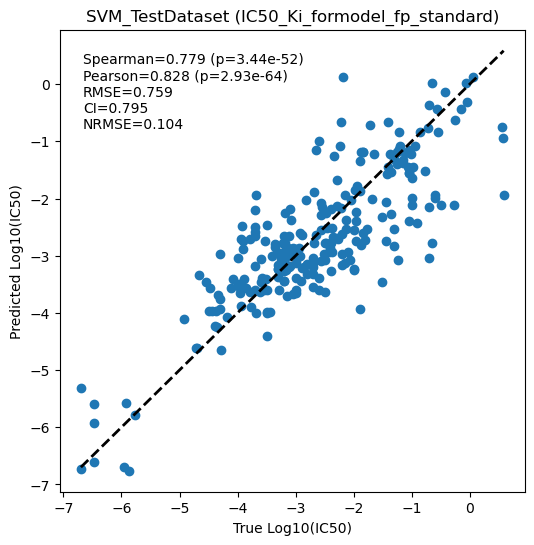

Fitting 10 folds for each of 18 candidates, totalling 180 fits


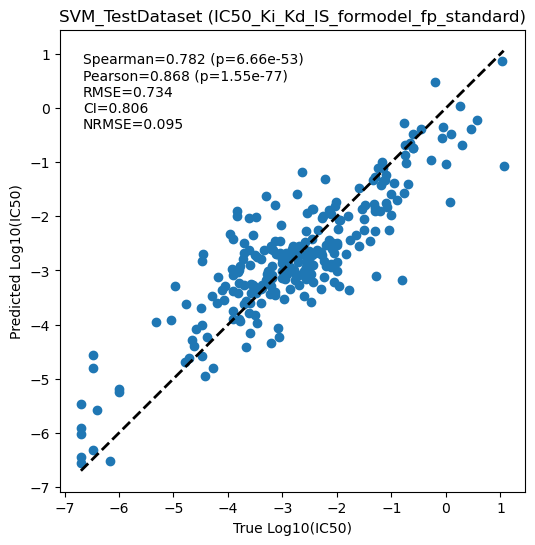

==== All done ====
Summary saved to: C:\ROOT\CK2 code\parameter\SVM_all_files_summary.csv


,file,best_params,best_cv_neg_mse,test_spearman,test_pearson,test_rmse,test_ci,test_nrmse,cv_results_csv,model_pkl
0,IC50_formodel_fp_standard.csv,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",-0.544151,0.852478,0.881955,0.745819,0.837670,0.096126,C:\ROOT\CK2 code\parameter\SVM_IC50_formodel_f...,C:\ROOT\CK2 code\parameter\SVM_IC50_formodel_f...
1,IC50_Kd_formodel_fp_standard.csv,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",-0.612611,0.783333,0.841806,0.787049,0.806382,0.103632,C:\ROOT\CK2 code\parameter\SVM_IC50_Kd_formode...,C:\ROOT\CK2 code\parameter\SVM_IC50_Kd_formode...
2,IC50_Ki_formodel_fp_standard.csv,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",-0.578271,0.779007,0.828033,0.759137,0.795184,0.104220,C:\ROOT\CK2 code\parameter\SVM_IC50_Ki_formode...,C:\ROOT\CK2 code\parameter\SVM_IC50_Ki_formode...
3,IC50_Ki_Kd_IS_formodel_fp_standard.csv,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",-0.617948,0.782312,0.868463,0.733921,0.806318,0.094593,C:\ROOT\CK2 code\parameter\SVM_IC50_Ki_Kd_IS_f...,C:\ROOT\CK2 code\parameter\SVM_IC50_Ki_Kd_IS_f...


In [2]:
%matplotlib inline

# =========================
# Basic libraries / 基础库
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from lifelines.utils import concordance_index
import pickle


# ============================================================
# 1) Path configuration / 路径配置（根据本地环境自行修改）
# ============================================================
data_path = Path(r"C:\\ROOT\\CK2 code")
parameter_path = data_path / "parameter"
plot_path = data_path / "plot"

# Create output directories if they do not exist
# 如果输出目录不存在，则自动创建
parameter_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)


# ============================================================
# 2) Input file list / 需要处理的数据文件列表
# ============================================================
file_list = [
    "IC50_formodel_fp_standard.csv",
    "IC50_Kd_formodel_fp_standard.csv",
    "IC50_Ki_formodel_fp_standard.csv",
    "IC50_Ki_Kd_IS_formodel_fp_standard.csv",
]


# ============================================================
# 3) Global configuration / 全局参数设置
# ============================================================
RANDOM_SEED = 42          # Random seed for reproducibility / 随机种子，保证可复现
N_SAMPLE = 1000           # Number of sampled compounds / 抽样化合物数量
TRAIN_SIZE = 0.75         # Train-test split ratio / 训练集比例

# Hyperparameter grid for SVR / SVR 网格搜索参数
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": [1, 0.1, 0.01],
}

# Columns to be removed from feature matrix
# 需要从特征中删除的非描述符列
drop_cols_default = [
    "Unnamed: 0",
    "realsmiles",
    "is_biochemical",
    "Log10",
    "is_cellbased",
    "id",
    "type",
    "value",
]


# ============================================================
# 4) Utility functions / 工具函数
# ============================================================
def safe_drop(df: pd.DataFrame, cols):
    """
    Safely drop columns that exist in the DataFrame.
    安全删除存在的列，避免不同 CSV 结构差异导致报错。
    """
    cols_exist = [c for c in cols if c in df.columns]
    return df.drop(cols_exist, axis=1)


def compute_metrics(y_true, y_pred):
    """
    Compute evaluation metrics for regression.
    计算回归任务的多种评估指标。
    """
    sp = spearmanr(y_true, y_pred)
    pe = pearsonr(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    # Normalized RMSE
    # 归一化 RMSE
    if np.max(y_true) - np.min(y_true) != 0:
        nrmse = float(rmse / (np.max(y_true) - np.min(y_true)))
    else:
        nrmse = np.nan

    # Concordance index
    # 一致性指数（CI）
    ci = float(concordance_index(y_true, y_pred))

    return sp, pe, rmse, nrmse, ci


def scatter_plot(y_true, y_pred, title, xlabel, ylabel, out_file: Path):
    """
    Generate scatter plot with performance statistics.
    绘制预测值 vs 真实值散点图，并标注统计指标。
    """
    sp, pe, rmse, nrmse, ci = compute_metrics(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))

    # Scatter plot
    # 散点图
    ax.scatter(y_true, y_pred)

    # 45-degree reference line
    # 45 度参考线（理想预测）
    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    ax.plot([mn, mx], [mn, mx], "k--", lw=2)

    # Statistics text box
    # 指标文本框
    text = (
        f"Spearman={sp.statistic:.3f} (p={sp.pvalue:.2e})\n"
        f"Pearson={pe.statistic:.3f} (p={pe.pvalue:.2e})\n"
        f"RMSE={rmse:.3f}\n"
        f"CI={ci:.3f}\n"
        f"NRMSE={nrmse:.3f}"
    )

    ax.text(
        0.05,
        0.95,
        text,
        transform=ax.transAxes,
        ha="left",
        va="top",
        bbox={"facecolor": "white", "edgecolor": "none"},
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Save figure
    # 保存图像
    fig.savefig(out_file, dpi=500, bbox_inches="tight")
    plt.show()


# ============================================================
# 5) Main loop: iterate over all datasets
# 主循环：逐个数据集训练与评估
# ============================================================
all_summary = []

for fname in file_list:
    fpath = data_path / fname

    # Skip missing files
    # 如果文件不存在则跳过
    if not fpath.exists():
        print(f"[Skipped] File not found: {fpath}")
        continue

    tag = Path(fname).stem  # File identifier / 文件标识名

    # --------------------------------------------------------
    # Load and sample dataset
    # 读取并随机抽样数据
    # --------------------------------------------------------
    df = pd.read_csv(fpath, sep=",")
    df = df.sample(n=min(N_SAMPLE, len(df)), random_state=RANDOM_SEED).copy()

    # Column name normalization
    # 列名规范化（兼容不同文件）
    if "is_cell.based" in df.columns and "is_cellbased" not in df.columns:
        df.rename(columns={"is_cell.based": "is_cellbased"}, inplace=True)

    # --------------------------------------------------------
    # Feature matrix and target vector
    # 构建特征矩阵 X 和标签 y
    # --------------------------------------------------------
    if "Log10" not in df.columns:
        raise ValueError(f"{fname} does not contain 'Log10' column.")

    X = safe_drop(df, drop_cols_default)
    y = df["Log10"].values

    # Train-test split (KEEP EXACTLY AS BEFORE)
    # 划分训练集与测试集（保持不变）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=TRAIN_SIZE, random_state=0
    )

    # --------------------------------------------------------
    # Model training with grid search
    # 使用 GridSearchCV 训练 SVR 模型
    # --------------------------------------------------------
    base_model = SVR(kernel="rbf", C=1.0, gamma="scale")

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",
        cv=10,
        n_jobs=-1,
        verbose=1,
    )

    grid.fit(X_train, y_train)

    # Save cross-validation results
    # 保存交叉验证结果
    cv_results = pd.DataFrame(grid.cv_results_)
    cv_results_out = parameter_path / f"SVM_{tag}_CVResults.csv"
    cv_results.to_csv(cv_results_out, index=False)

    # Best model
    # 最优模型
    best_model = grid.best_estimator_

    # --------------------------------------------------------
    # Prediction and evaluation
    # 预测与评估
    # --------------------------------------------------------
    y_pred_test = best_model.predict(X_test)
    sp_te, pe_te, rmse_te, nrmse_te, ci_te = compute_metrics(y_test, y_pred_test)

    # Save trained model
    # 保存模型
    model_out = parameter_path / f"SVM_{tag}_best_model.pkl"
    with open(model_out, "wb") as f:
        pickle.dump(best_model, f)

    # --------------------------------------------------------
    # Visualization 
    # 结果可视化
    # --------------------------------------------------------
    scatter_plot(
        y_test,
        y_pred_test,
        title=f"SVM_TestDataset ({tag})",
        xlabel="True Log10(IC50)",
        ylabel="Predicted Log10(IC50)",
        out_file=plot_path / f"SVM_{tag}_test.pdf",
    )

    # --------------------------------------------------------
    # Summary record 
    # 汇总当前数据集结果
    # --------------------------------------------------------
    all_summary.append({
        "file": fname,
        "best_params": grid.best_params_,
        "best_cv_neg_mse": grid.best_score_,
        "test_spearman": sp_te.statistic,
        "test_pearson": pe_te.statistic,
        "test_rmse": rmse_te,
        "test_ci": ci_te,
        "test_nrmse": nrmse_te,
        "cv_results_csv": str(cv_results_out),
        "model_pkl": str(model_out),
    })

# Save overall summary
# 保存所有数据集的汇总结果
summary_df = pd.DataFrame(all_summary)
summary_out = parameter_path / "SVM_all_files_summary.csv"
summary_df.to_csv(summary_out, index=False)

print("==== All done ====")
print("Summary saved to:", summary_out)
summary_df


In [3]:
### RF model###

Fitting 10 folds for each of 6 candidates, totalling 60 fits


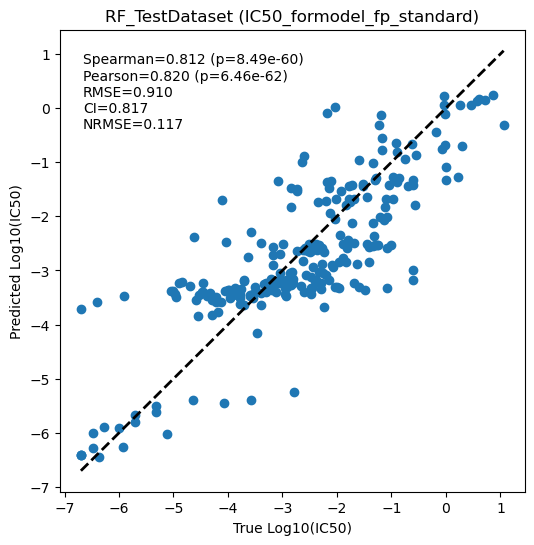

Fitting 10 folds for each of 6 candidates, totalling 60 fits


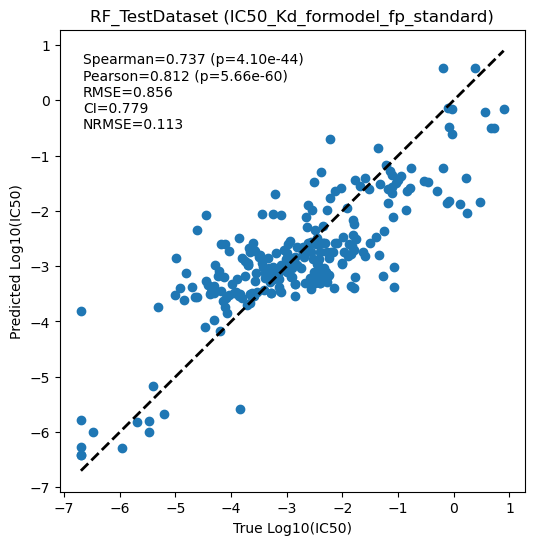

Fitting 10 folds for each of 6 candidates, totalling 60 fits


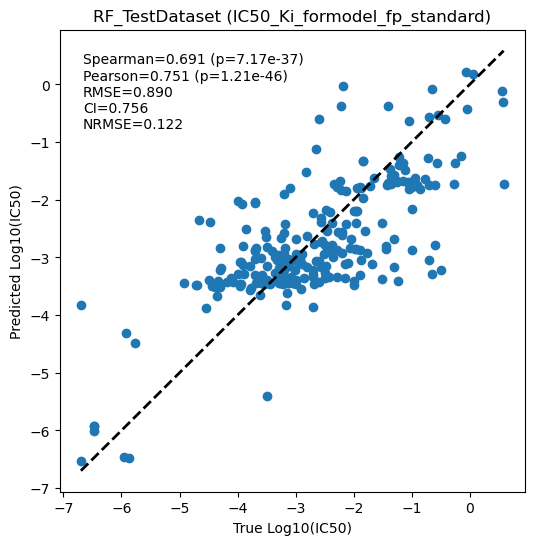

Fitting 10 folds for each of 6 candidates, totalling 60 fits


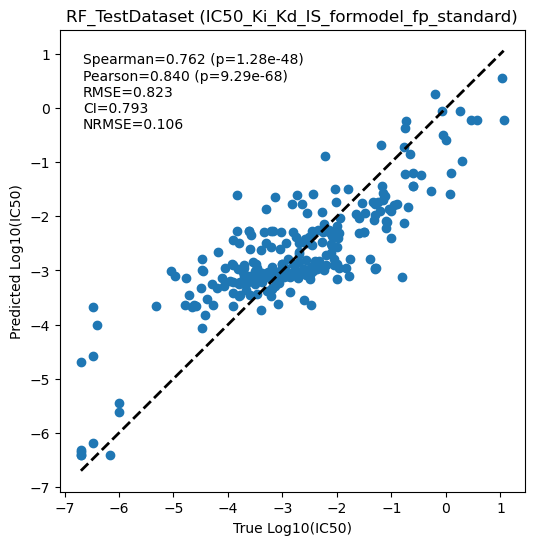

==== All done ====
Summary saved to: C:\ROOT\CK2 code\parameter\RF_all_files_summary.csv


,file,best_params,best_cv_neg_mse,test_spearman,test_pearson,test_rmse,test_ci,test_nrmse,cv_results_csv,model_pkl
0,IC50_formodel_fp_standard.csv,"{'max_depth': 6, 'n_estimators': 100}",-0.680333,0.811503,0.819562,0.910002,0.816522,0.117287,C:\ROOT\CK2 code\parameter\RF_IC50_formodel_fp...,C:\ROOT\CK2 code\parameter\RF_IC50_formodel_fp...
1,IC50_Kd_formodel_fp_standard.csv,"{'max_depth': 6, 'n_estimators': 100}",-0.645975,0.737185,0.812188,0.856008,0.779088,0.112712,C:\ROOT\CK2 code\parameter\RF_IC50_Kd_formodel...,C:\ROOT\CK2 code\parameter\RF_IC50_Kd_formodel...
2,IC50_Ki_formodel_fp_standard.csv,"{'max_depth': 6, 'n_estimators': 500}",-0.723435,0.691363,0.751222,0.889974,0.755912,0.122182,C:\ROOT\CK2 code\parameter\RF_IC50_Ki_formodel...,C:\ROOT\CK2 code\parameter\RF_IC50_Ki_formodel...
3,IC50_Ki_Kd_IS_formodel_fp_standard.csv,"{'max_depth': 6, 'n_estimators': 500}",-0.735720,0.761565,0.839868,0.823039,0.793428,0.106079,C:\ROOT\CK2 code\parameter\RF_IC50_Ki_Kd_IS_fo...,C:\ROOT\CK2 code\parameter\RF_IC50_Ki_Kd_IS_fo...


In [4]:
%matplotlib inline

# =========================
# Basic libraries / 基础库
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from lifelines.utils import concordance_index
import pickle


# ============================================================
# 1) Path configuration / 路径配置（根据本地环境自行修改）
# ============================================================
# NOTE: This should be the folder that directly contains the CSV files.
# 注意：这里必须是“直接包含CSV文件”的那个文件夹
data_path = Path(r"C:\\ROOT\\CK2 code")

parameter_path = data_path / "parameter"
plot_path = data_path / "plot"

# Create output directories if they do not exist
# 如果输出目录不存在，则自动创建
parameter_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)


# ============================================================
# 2) Input file list / 需要处理的数据文件列表
# ============================================================
file_list = [
    "IC50_formodel_fp_standard.csv",
    "IC50_Kd_formodel_fp_standard.csv",
    "IC50_Ki_formodel_fp_standard.csv",
    "IC50_Ki_Kd_IS_formodel_fp_standard.csv",
]


# ============================================================
# 3) Global configuration / 全局参数设置
# ============================================================
RANDOM_SEED = 42          # Random seed for reproducibility / 随机种子，保证可复现
N_SAMPLE = 1000           # Number of sampled compounds / 抽样化合物数量
TRAIN_SIZE = 0.75         # Train-test split ratio / 训练集比例

# Hyperparameter grid for RF / RF 网格搜索参数
param_grid = {
    "max_depth": [4, 6],
    "n_estimators": [10, 100, 500],
}

# Columns to be removed from feature matrix
# 需要从特征中删除的非描述符列
drop_cols_default = [
    "Unnamed: 0",
    "realsmiles",
    "is_biochemical",
    "Log10",
    "is_cellbased",
    "id",
    "type",
    "value",
]


# ============================================================
# 4) Utility functions / 工具函数
# ============================================================
def safe_drop(df: pd.DataFrame, cols):
    """
    Safely drop columns that exist in the DataFrame.
    安全删除存在的列，避免不同 CSV 结构差异导致报错。
    """
    cols_exist = [c for c in cols if c in df.columns]
    return df.drop(cols_exist, axis=1)


def compute_metrics(y_true, y_pred):
    """
    Compute evaluation metrics for regression.
    计算回归任务的多种评估指标。
    """
    sp = spearmanr(y_true, y_pred)
    pe = pearsonr(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    # Normalized RMSE
    # 归一化 RMSE
    denom = float(np.max(y_true) - np.min(y_true))
    nrmse = float(rmse / denom) if denom != 0 else np.nan

    # Concordance index
    # 一致性指数（CI）
    ci = float(concordance_index(y_true, y_pred))

    return sp, pe, rmse, nrmse, ci


def scatter_plot(y_true, y_pred, title, xlabel, ylabel, out_file: Path):
    """
    Generate scatter plot with performance statistics.
    绘制预测值 vs 真实值散点图，并标注统计指标。
    """
    sp, pe, rmse, nrmse, ci = compute_metrics(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))

    # Scatter plot
    # 散点图
    ax.scatter(y_true, y_pred)

    # 45-degree reference line
    # 45 度参考线（理想预测）
    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    ax.plot([mn, mx], [mn, mx], "k--", lw=2)

    # Statistics text box
    # 指标文本框
    text = (
        f"Spearman={sp.statistic:.3f} (p={sp.pvalue:.2e})\n"
        f"Pearson={pe.statistic:.3f} (p={pe.pvalue:.2e})\n"
        f"RMSE={rmse:.3f}\n"
        f"CI={ci:.3f}\n"
        f"NRMSE={nrmse:.3f}"
    )

    ax.text(
        0.05,
        0.95,
        text,
        transform=ax.transAxes,
        ha="left",
        va="top",
        bbox={"facecolor": "white", "edgecolor": "none"},
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Save figure
    # 保存图像
    fig.savefig(out_file, dpi=500, bbox_inches="tight")
    plt.show()


# ============================================================
# 5) Main loop: iterate over all datasets
# 主循环：逐个数据集训练与评估
# ============================================================
all_summary = []

for fname in file_list:
    fpath = data_path / fname

    # Skip missing files
    # 如果文件不存在则跳过
    if not fpath.exists():
        print(f"[Skipped] File not found: {fpath}")
        continue

    tag = Path(fname).stem  # File identifier / 文件标识名

    # --------------------------------------------------------
    # Load and sample dataset
    # 读取并随机抽样数据
    # --------------------------------------------------------
    df = pd.read_csv(fpath, sep=",")
    df = df.sample(n=min(N_SAMPLE, len(df)), random_state=RANDOM_SEED).copy()

    # Column name normalization
    # 列名规范化（兼容不同文件）
    if "is_cell.based" in df.columns and "is_cellbased" not in df.columns:
        df.rename(columns={"is_cell.based": "is_cellbased"}, inplace=True)

    # --------------------------------------------------------
    # Feature matrix and target vector
    # 构建特征矩阵 X 和标签 y
    # --------------------------------------------------------
    if "Log10" not in df.columns:
        raise ValueError(f"{fname} does not contain 'Log10' column.")

    X = safe_drop(df, drop_cols_default)
    y = df["Log10"].values

    # Optional safety checks (do not change results)
    # 可选安全检查（不改变结果，只用于提前暴露问题）
    assert X.select_dtypes(exclude=[np.number]).shape[1] == 0, "X contains non-numeric columns!"
    assert np.isfinite(X.to_numpy()).all(), "X contains NaN/inf!"
    assert np.isfinite(y).all(), "y contains NaN/inf!"

    # Train-test split (KEEP EXACTLY AS BEFORE)
    # 划分训练集与测试集（保持不变）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=TRAIN_SIZE, random_state=0
    )

    # --------------------------------------------------------
    # Model training with grid search (RF)
    # 使用 GridSearchCV 训练 RF 回归模型
    # --------------------------------------------------------
    base_model = RandomForestRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1
    )

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",  # maximize -MSE == minimize MSE
        cv=10,
        n_jobs=-1,
        verbose=1,
    )

    grid.fit(X_train, y_train)

    # Save cross-validation results
    # 保存交叉验证结果
    cv_results = pd.DataFrame(grid.cv_results_)
    cv_results_out = parameter_path / f"RF_{tag}_CVResults.csv"
    cv_results.to_csv(cv_results_out, index=False)

    # Best model
    # 最优模型
    best_model = grid.best_estimator_

    # --------------------------------------------------------
    # Prediction and evaluation 
    # 预测与评估
    # --------------------------------------------------------
    y_pred_test = best_model.predict(X_test)
    sp_te, pe_te, rmse_te, nrmse_te, ci_te = compute_metrics(y_test, y_pred_test)

    # Save trained model
    # 保存模型
    model_out = parameter_path / f"RF_{tag}_best_model.pkl"
    with open(model_out, "wb") as f:
        pickle.dump(best_model, f)

    # --------------------------------------------------------
    # Visualization 
    # 结果可视化
    # --------------------------------------------------------
    scatter_plot(
        y_test,
        y_pred_test,
        title=f"RF_TestDataset ({tag})",
        xlabel="True Log10(IC50)",
        ylabel="Predicted Log10(IC50)",
        out_file=plot_path / f"RF_{tag}_test.pdf",
    )

    # --------------------------------------------------------
    # Summary record 
    # 汇总当前数据集结果
    # --------------------------------------------------------
    all_summary.append({
        "file": fname,
        "best_params": grid.best_params_,
        "best_cv_neg_mse": grid.best_score_,
        "test_spearman": sp_te.statistic,
        "test_pearson": pe_te.statistic,
        "test_rmse": rmse_te,
        "test_ci": ci_te,
        "test_nrmse": nrmse_te,
        "cv_results_csv": str(cv_results_out),
        "model_pkl": str(model_out),
    })

# Save overall summary
# 保存所有数据集的汇总结果
summary_df = pd.DataFrame(all_summary)
summary_out = parameter_path / "RF_all_files_summary.csv"
summary_df.to_csv(summary_out, index=False)

print("==== All done ====")
print("Summary saved to:", summary_out)
summary_df


In [5]:
### GBDT model###

Fitting 10 folds for each of 8 candidates, totalling 80 fits


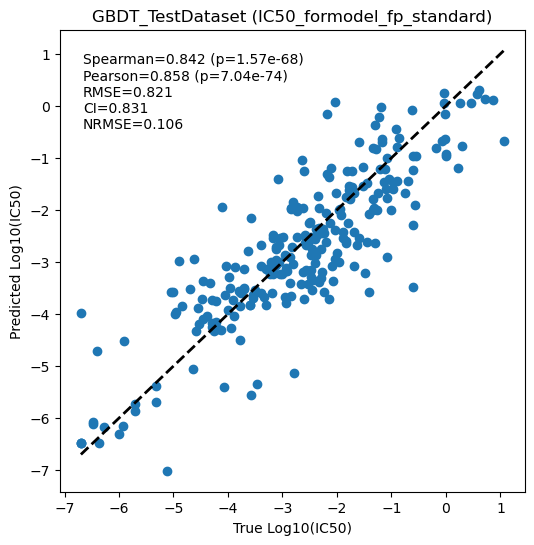

Fitting 10 folds for each of 8 candidates, totalling 80 fits


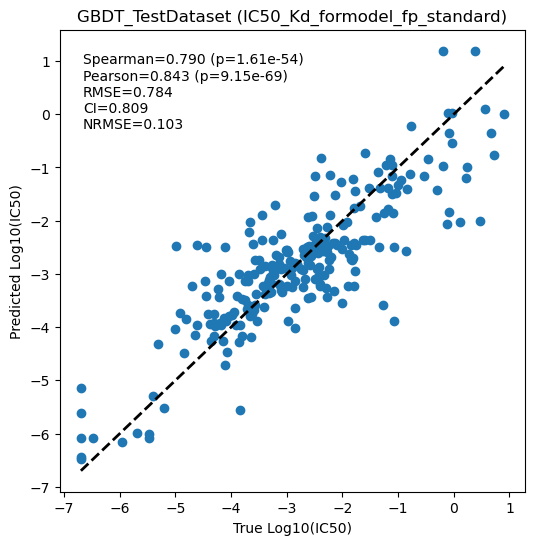

Fitting 10 folds for each of 8 candidates, totalling 80 fits


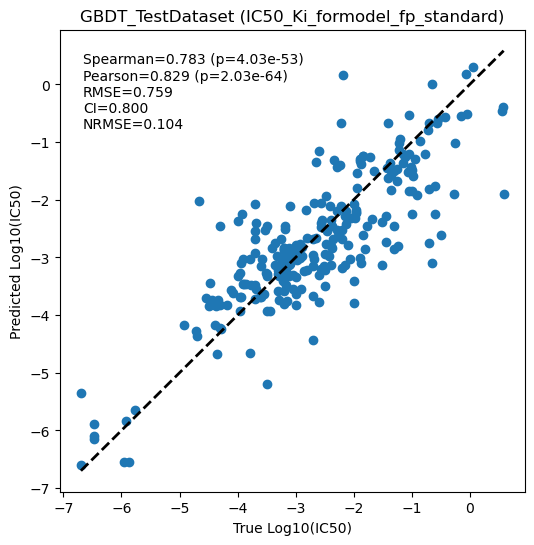

Fitting 10 folds for each of 8 candidates, totalling 80 fits


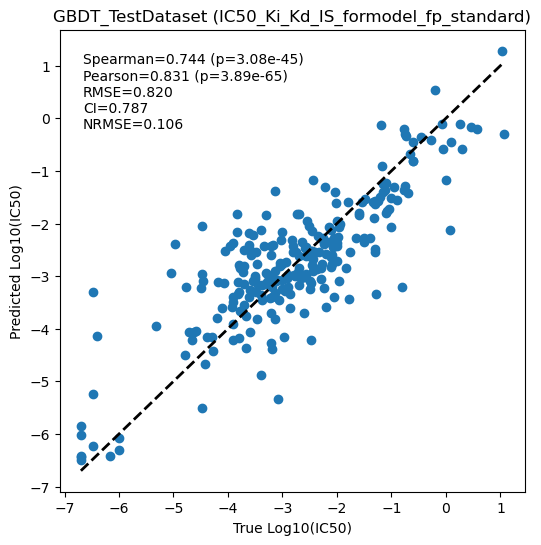

Fitting 10 folds for each of 8 candidates, totalling 80 fits


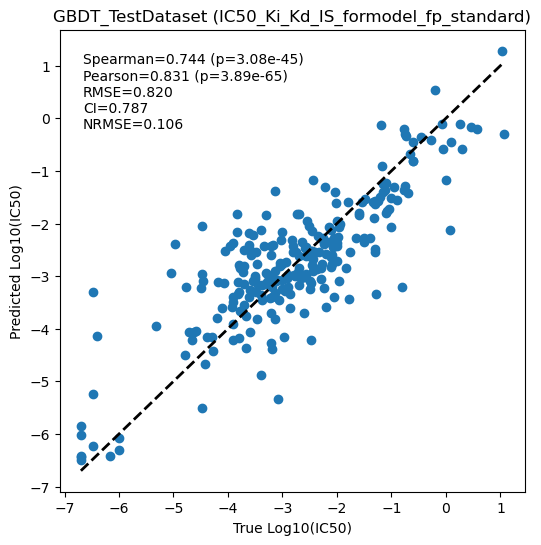

==== All done ====
Summary saved to: C:\ROOT\CK2 code\parameter\GBDT_all_files_summary.csv


,file,best_params,best_cv_neg_mse,test_spearman,test_pearson,test_rmse,test_ci,test_nrmse,cv_results_csv,model_pkl
0,IC50_formodel_fp_standard.csv,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-0.555046,0.842354,0.858478,0.821318,0.830835,0.105857,C:\ROOT\CK2 code\parameter\GBDT_IC50_formodel_...,C:\ROOT\CK2 code\parameter\GBDT_IC50_formodel_...
1,IC50_Kd_formodel_fp_standard.csv,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-0.594415,0.789593,0.843105,0.784420,0.808859,0.103286,C:\ROOT\CK2 code\parameter\GBDT_IC50_Kd_formod...,C:\ROOT\CK2 code\parameter\GBDT_IC50_Kd_formod...
2,IC50_Ki_formodel_fp_standard.csv,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-0.623733,0.783311,0.828592,0.758597,0.800274,0.104146,C:\ROOT\CK2 code\parameter\GBDT_IC50_Ki_formod...,C:\ROOT\CK2 code\parameter\GBDT_IC50_Ki_formod...
3,IC50_Ki_Kd_IS_formodel_fp_standard.csv,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",-0.635046,0.743534,0.831088,0.820249,0.787457,0.105719,C:\ROOT\CK2 code\parameter\GBDT_IC50_Ki_Kd_IS_...,C:\ROOT\CK2 code\parameter\GBDT_IC50_Ki_Kd_IS_...
4,IC50_Ki_Kd_IS_formodel_fp_standard.csv,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",-0.635046,0.743534,0.831088,0.820249,0.787457,0.105719,C:\ROOT\CK2 code\parameter\GBDT_IC50_Ki_Kd_IS_...,C:\ROOT\CK2 code\parameter\GBDT_IC50_Ki_Kd_IS_...


In [6]:
%matplotlib inline

# =========================
# Basic libraries / 基础库
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from lifelines.utils import concordance_index
import pickle


# ============================================================
# 1) Path configuration / 路径配置（根据本地环境自行修改）
# ============================================================
# NOTE: This should be the folder that directly contains the CSV files.
# 注意：这里必须是“直接包含CSV文件”的那个文件夹
data_path = Path(r"C:\\ROOT\\CK2 code")

parameter_path = data_path / "parameter"
plot_path = data_path / "plot"

# Create output directories if they do not exist
# 如果输出目录不存在，则自动创建
parameter_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)


# ============================================================
# 2) Input file list / 需要处理的数据文件列表
# ============================================================
file_list = [
    "IC50_formodel_fp_standard.csv",
    "IC50_Kd_formodel_fp_standard.csv",
    "IC50_Ki_formodel_fp_standard.csv",
    "IC50_Ki_Kd_IS_formodel_fp_standard.csv",
    "IC50_Ki_Kd_IS_formodel_fp_standard.csv",
]


# ============================================================
# 3) Global configuration / 全局参数设置
# ============================================================
RANDOM_SEED = 42          # Random seed for reproducibility / 随机种子，保证可复现
N_SAMPLE = 1000           # Number of sampled compounds / 抽样化合物数量
TRAIN_SIZE = 0.75         # Train-test split ratio / 训练集比例

# Hyperparameter grid for GBDT / GBDT 网格搜索参数
param_grid = {
    "max_depth": [3, 6],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 1000],
}

# Columns to be removed from feature matrix
# 需要从特征中删除的非描述符列
drop_cols_default = [
    "Unnamed: 0",
    "realsmiles",
    "is_biochemical",
    "Log10",
    "is_cellbased",
    "id",
    "type",
    "value",
]


# ============================================================
# 4) Utility functions / 工具函数
# ============================================================
def safe_drop(df: pd.DataFrame, cols):
    """
    Safely drop columns that exist in the DataFrame.
    安全删除存在的列，避免不同 CSV 结构差异导致报错。
    """
    cols_exist = [c for c in cols if c in df.columns]
    return df.drop(cols_exist, axis=1)


def compute_metrics(y_true, y_pred):
    """
    Compute evaluation metrics for regression.
    计算回归任务的多种评估指标。
    """
    sp = spearmanr(y_true, y_pred)
    pe = pearsonr(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    # Normalized RMSE
    # 归一化 RMSE
    denom = float(np.max(y_true) - np.min(y_true))
    nrmse = float(rmse / denom) if denom != 0 else np.nan

    # Concordance index
    # 一致性指数（CI）
    ci = float(concordance_index(y_true, y_pred))

    return sp, pe, rmse, nrmse, ci


def scatter_plot(y_true, y_pred, title, xlabel, ylabel, out_file: Path):
    """
    Generate scatter plot with performance statistics.
    绘制预测值 vs 真实值散点图，并标注统计指标。
    """
    sp, pe, rmse, nrmse, ci = compute_metrics(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))

    # Scatter plot
    # 散点图
    ax.scatter(y_true, y_pred)

    # 45-degree reference line
    # 45 度参考线（理想预测）
    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    ax.plot([mn, mx], [mn, mx], "k--", lw=2)

    # Statistics text box
    # 指标文本框
    text = (
        f"Spearman={sp.statistic:.3f} (p={sp.pvalue:.2e})\n"
        f"Pearson={pe.statistic:.3f} (p={pe.pvalue:.2e})\n"
        f"RMSE={rmse:.3f}\n"
        f"CI={ci:.3f}\n"
        f"NRMSE={nrmse:.3f}"
    )

    ax.text(
        0.05,
        0.95,
        text,
        transform=ax.transAxes,
        ha="left",
        va="top",
        bbox={"facecolor": "white", "edgecolor": "none"},
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Save figure
    # 保存图像
    fig.savefig(out_file, dpi=500, bbox_inches="tight")
    plt.show()


# ============================================================
# 5) Main loop: iterate over all datasets
# 主循环：逐个数据集训练与评估
# ============================================================
all_summary = []

for fname in file_list:
    fpath = data_path / fname

    # Skip missing files
    # 如果文件不存在则跳过
    if not fpath.exists():
        print(f"[Skipped] File not found: {fpath}")
        continue

    tag = Path(fname).stem  # File identifier / 文件标识名

    # --------------------------------------------------------
    # Load and sample dataset
    # 读取并随机抽样数据
    # --------------------------------------------------------
    df = pd.read_csv(fpath, sep=",")
    df = df.sample(n=min(N_SAMPLE, len(df)), random_state=RANDOM_SEED).copy()

    # Column name normalization
    # 列名规范化（兼容不同文件）
    if "is_cell.based" in df.columns and "is_cellbased" not in df.columns:
        df.rename(columns={"is_cell.based": "is_cellbased"}, inplace=True)

    # --------------------------------------------------------
    # Feature matrix and target vector
    # 构建特征矩阵 X 和标签 y
    # --------------------------------------------------------
    if "Log10" not in df.columns:
        raise ValueError(f"{fname} does not contain 'Log10' column.")

    X = safe_drop(df, drop_cols_default)
    y = df["Log10"].values

    # Optional safety checks (do not change results)
    # 可选安全检查（不改变结果，只用于提前暴露问题）
    assert X.select_dtypes(exclude=[np.number]).shape[1] == 0, "X contains non-numeric columns!"
    assert np.isfinite(X.to_numpy()).all(), "X contains NaN/inf!"
    assert np.isfinite(y).all(), "y contains NaN/inf!"

    # Train-test split (KEEP EXACTLY AS BEFORE)
    # 划分训练集与测试集（保持不变）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=TRAIN_SIZE, random_state=0
    )

    # --------------------------------------------------------
    # Model training with grid search (GBDT)
    # 使用 GridSearchCV 训练 GBDT 回归模型
    # --------------------------------------------------------
    base_model = GradientBoostingRegressor(
        random_state=RANDOM_SEED
    )

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",  # maximize -MSE == minimize MSE
        cv=10,
        n_jobs=-1,
        verbose=1,
    )

    grid.fit(X_train, y_train)

    # Save cross-validation results
    # 保存交叉验证结果
    cv_results = pd.DataFrame(grid.cv_results_)
    cv_results_out = parameter_path / f"GBDT_{tag}_CVResults.csv"
    cv_results.to_csv(cv_results_out, index=False)

    # Best model
    # 最优模型
    best_model = grid.best_estimator_

    # --------------------------------------------------------
    # Prediction and evaluation 
    # 预测与评估
    # --------------------------------------------------------
    y_pred_test = best_model.predict(X_test)
    sp_te, pe_te, rmse_te, nrmse_te, ci_te = compute_metrics(y_test, y_pred_test)

    # Save trained model
    # 保存模型
    model_out = parameter_path / f"GBDT_{tag}_best_model.pkl"
    with open(model_out, "wb") as f:
        pickle.dump(best_model, f)

    # --------------------------------------------------------
    # Visualization 
    # 结果可视化
    # --------------------------------------------------------
    scatter_plot(
        y_test,
        y_pred_test,
        title=f"GBDT_TestDataset ({tag})",
        xlabel="True Log10(IC50)",
        ylabel="Predicted Log10(IC50)",
        out_file=plot_path / f"GBDT_{tag}_test.pdf",
    )

    # --------------------------------------------------------
    # Summary record 
    # 汇总当前数据集结果
    # --------------------------------------------------------
    all_summary.append({
        "file": fname,
        "best_params": grid.best_params_,
        "best_cv_neg_mse": grid.best_score_,
        "test_spearman": sp_te.statistic,
        "test_pearson": pe_te.statistic,
        "test_rmse": rmse_te,
        "test_ci": ci_te,
        "test_nrmse": nrmse_te,
        "cv_results_csv": str(cv_results_out),
        "model_pkl": str(model_out),
    })

# Save overall summary
# 保存所有数据集的汇总结果
summary_df = pd.DataFrame(all_summary)
summary_out = parameter_path / "GBDT_all_files_summary.csv"
summary_df.to_csv(summary_out, index=False)

print("==== All done ====")
print("Summary saved to:", summary_out)
summary_df


In [7]:
### XGBoost model ###

Fitting 10 folds for each of 8 candidates, totalling 80 fits


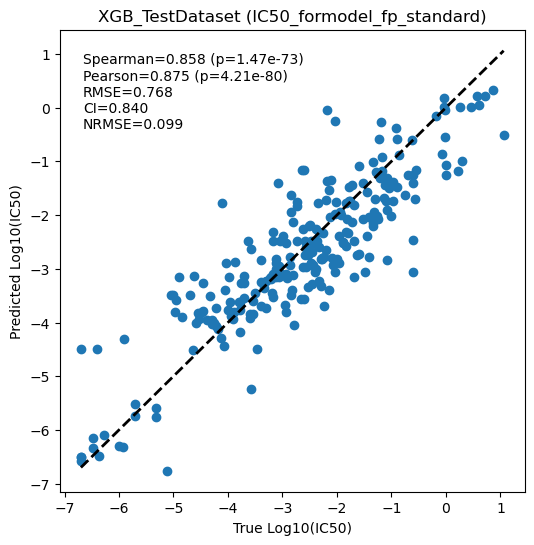

Fitting 10 folds for each of 8 candidates, totalling 80 fits


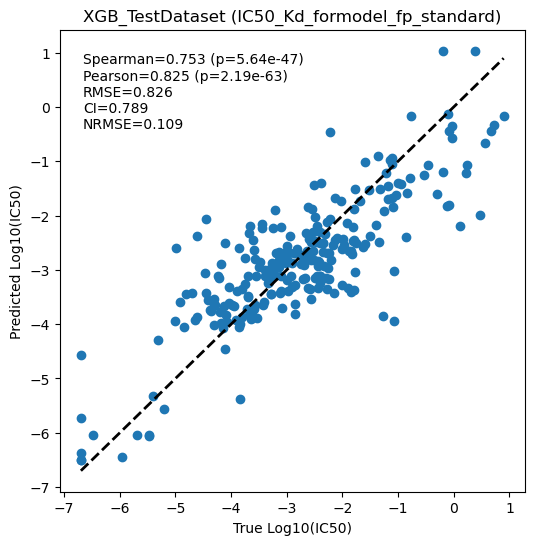

Fitting 10 folds for each of 8 candidates, totalling 80 fits


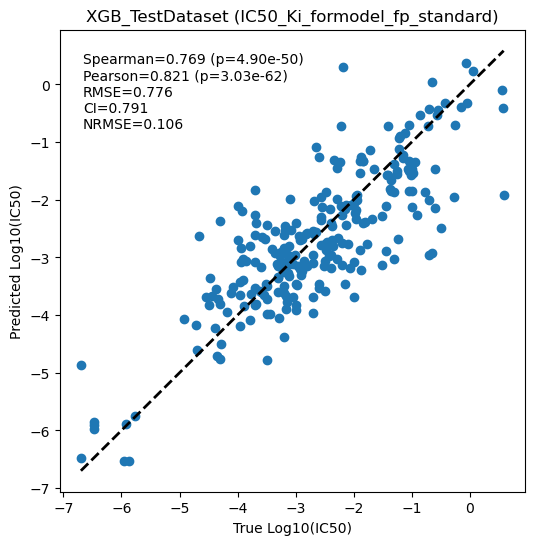

Fitting 10 folds for each of 8 candidates, totalling 80 fits


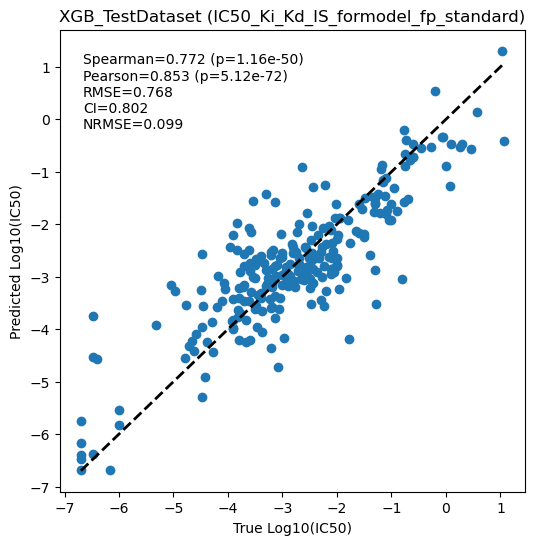

==== All done ====
Summary saved to: C:\ROOT\CK2 code\parameter\XGB_all_files_summary.csv


,file,best_params,best_cv_neg_mse,test_spearman,test_pearson,test_rmse,test_ci,test_nrmse,cv_results_csv,model_pkl
0,IC50_formodel_fp_standard.csv,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.583223,0.857569,0.875016,0.768341,0.839954,0.099029,C:\ROOT\CK2 code\parameter\XGB_IC50_formodel_f...,C:\ROOT\CK2 code\parameter\XGB_IC50_formodel_f...
1,IC50_Kd_formodel_fp_standard.csv,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.607146,0.752991,0.824928,0.825737,0.789221,0.108726,C:\ROOT\CK2 code\parameter\XGB_IC50_Kd_formode...,C:\ROOT\CK2 code\parameter\XGB_IC50_Kd_formode...
2,IC50_Ki_formodel_fp_standard.csv,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-0.613877,0.768670,0.820778,0.775649,0.790834,0.106487,C:\ROOT\CK2 code\parameter\XGB_IC50_Ki_formode...,C:\ROOT\CK2 code\parameter\XGB_IC50_Ki_formode...
3,IC50_Ki_Kd_IS_formodel_fp_standard.csv,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-0.635049,0.771726,0.853081,0.768084,0.801860,0.098996,C:\ROOT\CK2 code\parameter\XGB_IC50_Ki_Kd_IS_f...,C:\ROOT\CK2 code\parameter\XGB_IC50_Ki_Kd_IS_f...


In [8]:
%matplotlib inline

# =========================
# Basic libraries / 基础库
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from lifelines.utils import concordance_index
import pickle


# ============================================================
# 0) Import XGBoost / 导入 XGBoost
# ============================================================
# If you don't have xgboost installed, install via:
# pip install xgboost
# 如果没有安装 xgboost，可用 pip 安装：pip install xgboost
try:
    from xgboost import XGBRegressor
except Exception as e:
    raise ImportError(
        "Failed to import xgboost. Please install it first:\n"
        "  pip install xgboost\n"
        f"Original error: {e}"
    )


# ============================================================
# 1) Path configuration / 路径配置（根据本地环境自行修改）
# ============================================================
# NOTE: This should be the folder that directly contains the CSV files.
# 注意：这里必须是“直接包含CSV文件”的那个文件夹
data_path = Path(r"C:\\ROOT\\CK2 code")

parameter_path = data_path / "parameter"
plot_path = data_path / "plot"

# Create output directories if they do not exist
# 如果输出目录不存在，则自动创建
parameter_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)


# ============================================================
# 2) Input file list / 需要处理的数据文件列表
# ============================================================
file_list = [
    "IC50_formodel_fp_standard.csv",
    "IC50_Kd_formodel_fp_standard.csv",
    "IC50_Ki_formodel_fp_standard.csv",
    "IC50_Ki_Kd_IS_formodel_fp_standard.csv",
]


# ============================================================
# 3) Global configuration / 全局参数设置
# ============================================================
RANDOM_SEED = 42          # Random seed for reproducibility / 随机种子，保证可复现
N_SAMPLE = 1000           # Number of sampled compounds / 抽样化合物数量
TRAIN_SIZE = 0.75         # Train-test split ratio / 训练集比例

# Hyperparameter grid for XGBoost / XGBoost 网格搜索参数
param_grid = {
    "max_depth": [4, 8],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [500, 1000],
}

# Columns to be removed from feature matrix
# 需要从特征中删除的非描述符列
drop_cols_default = [
    "Unnamed: 0",
    "realsmiles",
    "is_biochemical",
    "Log10",
    "is_cellbased",
    "id",
    "type",
    "value",
]


# ============================================================
# 4) Utility functions / 工具函数
# ============================================================
def safe_drop(df: pd.DataFrame, cols):
    """
    Safely drop columns that exist in the DataFrame.
    安全删除存在的列，避免不同 CSV 结构差异导致报错。
    """
    cols_exist = [c for c in cols if c in df.columns]
    return df.drop(cols_exist, axis=1)


def compute_metrics(y_true, y_pred):
    """
    Compute evaluation metrics for regression.
    计算回归任务的多种评估指标。
    """
    sp = spearmanr(y_true, y_pred)
    pe = pearsonr(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    # Normalized RMSE
    # 归一化 RMSE
    denom = float(np.max(y_true) - np.min(y_true))
    nrmse = float(rmse / denom) if denom != 0 else np.nan

    # Concordance index
    # 一致性指数（CI）
    ci = float(concordance_index(y_true, y_pred))

    return sp, pe, rmse, nrmse, ci


def scatter_plot(y_true, y_pred, title, xlabel, ylabel, out_file: Path):
    """
    Generate scatter plot with performance statistics.
    绘制预测值 vs 真实值散点图，并标注统计指标。
    """
    sp, pe, rmse, nrmse, ci = compute_metrics(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))

    # Scatter plot
    # 散点图
    ax.scatter(y_true, y_pred)

    # 45-degree reference line
    # 45 度参考线（理想预测）
    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    ax.plot([mn, mx], [mn, mx], "k--", lw=2)

    # Statistics text box
    # 指标文本框
    text = (
        f"Spearman={sp.statistic:.3f} (p={sp.pvalue:.2e})\n"
        f"Pearson={pe.statistic:.3f} (p={pe.pvalue:.2e})\n"
        f"RMSE={rmse:.3f}\n"
        f"CI={ci:.3f}\n"
        f"NRMSE={nrmse:.3f}"
    )

    ax.text(
        0.05,
        0.95,
        text,
        transform=ax.transAxes,
        ha="left",
        va="top",
        bbox={"facecolor": "white", "edgecolor": "none"},
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Save figure
    # 保存图像
    fig.savefig(out_file, dpi=500, bbox_inches="tight")
    plt.show()


# ============================================================
# 5) Main loop: iterate over all datasets
# 主循环：逐个数据集训练与评估
# ============================================================
all_summary = []

for fname in file_list:
    fpath = data_path / fname

    # Skip missing files
    # 如果文件不存在则跳过
    if not fpath.exists():
        print(f"[Skipped] File not found: {fpath}")
        continue

    tag = Path(fname).stem  # File identifier / 文件标识名

    # --------------------------------------------------------
    # Load and sample dataset
    # 读取并随机抽样数据
    # --------------------------------------------------------
    df = pd.read_csv(fpath, sep=",")
    df = df.sample(n=min(N_SAMPLE, len(df)), random_state=RANDOM_SEED).copy()

    # Column name normalization
    # 列名规范化（兼容不同文件）
    if "is_cell.based" in df.columns and "is_cellbased" not in df.columns:
        df.rename(columns={"is_cell.based": "is_cellbased"}, inplace=True)

    # --------------------------------------------------------
    # Feature matrix and target vector
    # 构建特征矩阵 X 和标签 y
    # --------------------------------------------------------
    if "Log10" not in df.columns:
        raise ValueError(f"{fname} does not contain 'Log10' column.")

    X = safe_drop(df, drop_cols_default)
    y = df["Log10"].values

    # Optional safety checks (do not change results)
    # 可选安全检查（不改变结果，只用于提前暴露问题）
    assert X.select_dtypes(exclude=[np.number]).shape[1] == 0, "X contains non-numeric columns!"
    assert np.isfinite(X.to_numpy()).all(), "X contains NaN/inf!"
    assert np.isfinite(y).all(), "y contains NaN/inf!"

    # Train-test split (KEEP EXACTLY AS BEFORE)
    # 划分训练集与测试集（保持不变）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=TRAIN_SIZE, random_state=0
    )

    # --------------------------------------------------------
    # Model training with grid search (XGBoost)
    # 使用 GridSearchCV 训练 XGBoost 回归模型
    # --------------------------------------------------------
    base_model = XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        verbosity=0
    )

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",  # maximize -MSE == minimize MSE
        cv=10,
        n_jobs=-1,
        verbose=1,
    )

    grid.fit(X_train, y_train)

    # Save cross-validation results
    # 保存交叉验证结果
    cv_results = pd.DataFrame(grid.cv_results_)
    cv_results_out = parameter_path / f"XGB_{tag}_CVResults.csv"
    cv_results.to_csv(cv_results_out, index=False)

    # Best model
    # 最优模型
    best_model = grid.best_estimator_

    # --------------------------------------------------------
    # Prediction and evaluation 
    # 预测与评估
    # --------------------------------------------------------
    y_pred_test = best_model.predict(X_test)
    sp_te, pe_te, rmse_te, nrmse_te, ci_te = compute_metrics(y_test, y_pred_test)

    # Save trained model
    # 保存模型
    model_out = parameter_path / f"XGB_{tag}_best_model.pkl"
    with open(model_out, "wb") as f:
        pickle.dump(best_model, f)

    # --------------------------------------------------------
    # Visualization 
    # 结果可视化
    # --------------------------------------------------------
    scatter_plot(
        y_test,
        y_pred_test,
        title=f"XGB_TestDataset ({tag})",
        xlabel="True Log10(IC50)",
        ylabel="Predicted Log10(IC50)",
        out_file=plot_path / f"XGB_{tag}_test.pdf",
    )

    # --------------------------------------------------------
    # Summary record 
    # 汇总当前数据集结果
    # --------------------------------------------------------
    all_summary.append({
        "file": fname,
        "best_params": grid.best_params_,
        "best_cv_neg_mse": grid.best_score_,
        "test_spearman": sp_te.statistic,
        "test_pearson": pe_te.statistic,
        "test_rmse": rmse_te,
        "test_ci": ci_te,
        "test_nrmse": nrmse_te,
        "cv_results_csv": str(cv_results_out),
        "model_pkl": str(model_out),
    })

# Save overall summary
# 保存所有数据集的汇总结果
summary_df = pd.DataFrame(all_summary)
summary_out = parameter_path / "XGB_all_files_summary.csv"
summary_df.to_csv(summary_out, index=False)

print("==== All done ====")
print("Summary saved to:", summary_out)
summary_df


In [9]:
### ANN model ###

Fitting 10 folds for each of 16 candidates, totalling 160 fits


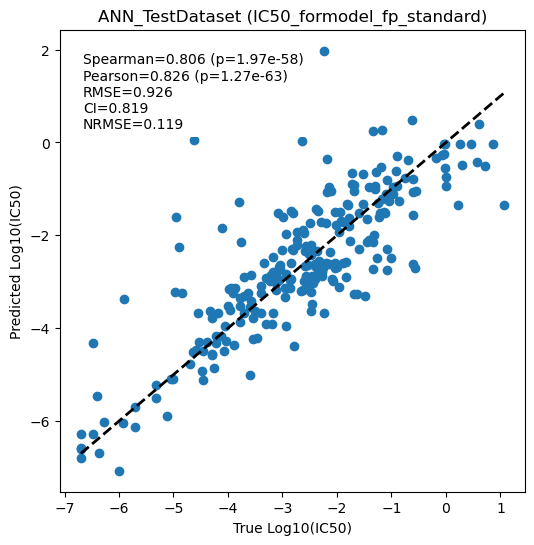

Fitting 10 folds for each of 16 candidates, totalling 160 fits


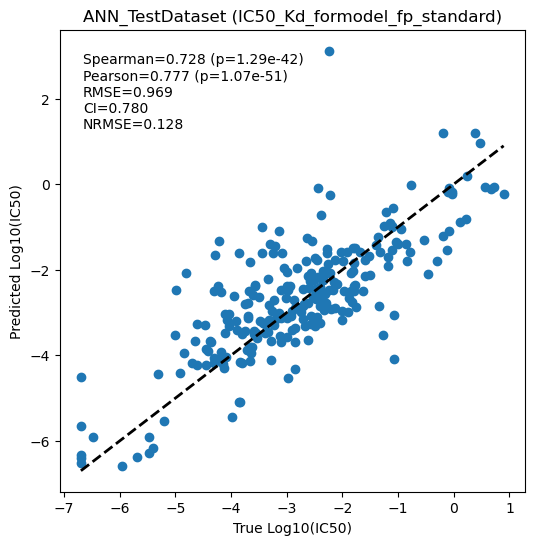

Fitting 10 folds for each of 16 candidates, totalling 160 fits


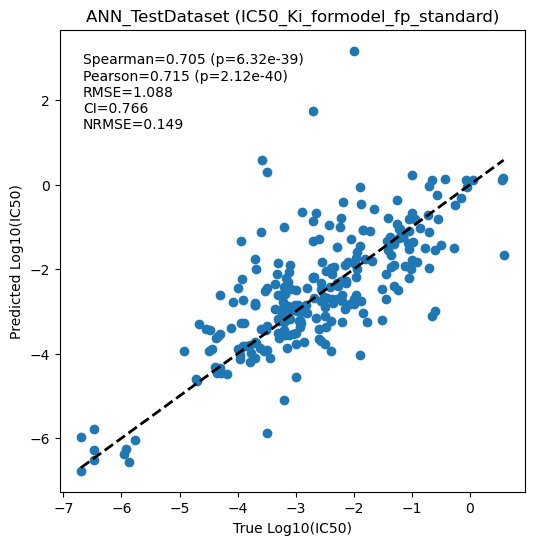

Fitting 10 folds for each of 16 candidates, totalling 160 fits


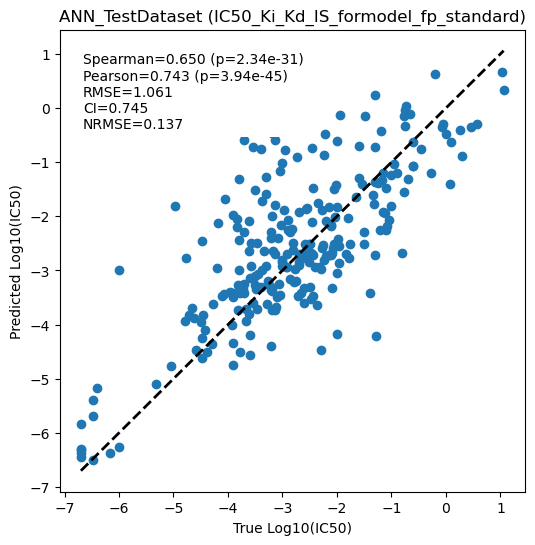

==== All done ====
Summary saved to: C:\ROOT\CK2 code\parameter\ANN_all_files_summary.csv


,file,best_params,best_cv_neg_mse,test_spearman,test_pearson,test_rmse,test_ci,test_nrmse,cv_results_csv,model_pkl
0,IC50_formodel_fp_standard.csv,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",-1.342112,0.806091,0.825779,0.925786,0.818758,0.119322,C:\ROOT\CK2 code\parameter\ANN_IC50_formodel_f...,C:\ROOT\CK2 code\parameter\ANN_IC50_formodel_f...
1,IC50_Kd_formodel_fp_standard.csv,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",-1.333645,0.728439,0.776683,0.968602,0.779811,0.127537,C:\ROOT\CK2 code\parameter\ANN_IC50_Kd_formode...,C:\ROOT\CK2 code\parameter\ANN_IC50_Kd_formode...
2,IC50_Ki_formodel_fp_standard.csv,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",-1.527375,0.705301,0.714826,1.088242,0.765706,0.149402,C:\ROOT\CK2 code\parameter\ANN_IC50_Ki_formode...,C:\ROOT\CK2 code\parameter\ANN_IC50_Ki_formode...
3,IC50_Ki_Kd_IS_formodel_fp_standard.csv,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",-1.729140,0.649614,0.742939,1.061015,0.744971,0.136751,C:\ROOT\CK2 code\parameter\ANN_IC50_Ki_Kd_IS_f...,C:\ROOT\CK2 code\parameter\ANN_IC50_Ki_Kd_IS_f...


In [10]:
%matplotlib inline

# =========================
# Basic libraries / 基础库
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from lifelines.utils import concordance_index
import pickle


# ============================================================
# 1) Path configuration / 路径配置（根据本地环境自行修改）
# ============================================================
# NOTE: This should be the folder that directly contains the CSV files.
# 注意：这里必须是“直接包含CSV文件”的那个文件夹
data_path = Path(r"C:\\ROOT\\CK2 code")

parameter_path = data_path / "parameter"
plot_path = data_path / "plot"

# Create output directories if they do not exist
# 如果输出目录不存在，则自动创建
parameter_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)


# ============================================================
# 2) Input file list / 需要处理的数据文件列表
# ============================================================
file_list = [
    "IC50_formodel_fp_standard.csv",
    "IC50_Kd_formodel_fp_standard.csv",
    "IC50_Ki_formodel_fp_standard.csv",
    "IC50_Ki_Kd_IS_formodel_fp_standard.csv",
]


# ============================================================
# 3) Global configuration / 全局参数设置
# ============================================================
RANDOM_SEED = 42          # Random seed for reproducibility / 随机种子，保证可复现
N_SAMPLE = 1000           # Number of sampled compounds / 抽样化合物数量
TRAIN_SIZE = 0.75         # Train-test split ratio / 训练集比例

# Hyperparameter grid for ANN (MLPRegressor) / ANN（MLP）网格搜索参数（
# NOTE: Because we use Pipeline, we need to prefix parameters with "mlp__".
# 注意：因为使用了 Pipeline，所以参数名前要加 "mlp__"
param_grid = {
    "mlp__hidden_layer_sizes": [(50,), (100,)],
    "mlp__activation": ["identity", "tanh"],
    "mlp__alpha": [0.0001, 0.001],
    "mlp__learning_rate_init": [0.001, 0.01],
}

# Columns to be removed from feature matrix
# 需要从特征中删除的非描述符列
drop_cols_default = [
    "Unnamed: 0",
    "realsmiles",
    "is_biochemical",
    "Log10",
    "is_cellbased",
    "id",
    "type",
    "value",
]


# ============================================================
# 4) Utility functions / 工具函数
# ============================================================
def safe_drop(df: pd.DataFrame, cols):
    """
    Safely drop columns that exist in the DataFrame.
    安全删除存在的列，避免不同 CSV 结构差异导致报错。
    """
    cols_exist = [c for c in cols if c in df.columns]
    return df.drop(cols_exist, axis=1)


def compute_metrics(y_true, y_pred):
    """
    Compute evaluation metrics for regression.
    计算回归任务的多种评估指标。
    """
    sp = spearmanr(y_true, y_pred)
    pe = pearsonr(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    # Normalized RMSE
    # 归一化 RMSE
    denom = float(np.max(y_true) - np.min(y_true))
    nrmse = float(rmse / denom) if denom != 0 else np.nan

    # Concordance index
    # 一致性指数（CI）
    ci = float(concordance_index(y_true, y_pred))

    return sp, pe, rmse, nrmse, ci


def scatter_plot(y_true, y_pred, title, xlabel, ylabel, out_file: Path):
    """
    Generate scatter plot with performance statistics.
    绘制预测值 vs 真实值散点图，并标注统计指标。
    """
    sp, pe, rmse, nrmse, ci = compute_metrics(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))

    # Scatter plot
    # 散点图
    ax.scatter(y_true, y_pred)

    # 45-degree reference line
    # 45 度参考线（理想预测）
    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    ax.plot([mn, mx], [mn, mx], "k--", lw=2)

    # Statistics text box
    # 指标文本框
    text = (
        f"Spearman={sp.statistic:.3f} (p={sp.pvalue:.2e})\n"
        f"Pearson={pe.statistic:.3f} (p={pe.pvalue:.2e})\n"
        f"RMSE={rmse:.3f}\n"
        f"CI={ci:.3f}\n"
        f"NRMSE={nrmse:.3f}"
    )

    ax.text(
        0.05,
        0.95,
        text,
        transform=ax.transAxes,
        ha="left",
        va="top",
        bbox={"facecolor": "white", "edgecolor": "none"},
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Save figure
    # 保存图像
    fig.savefig(out_file, dpi=500, bbox_inches="tight")
    plt.show()


# ============================================================
# 5) Main loop: iterate over all datasets
# 主循环：逐个数据集训练与评估
# ============================================================
all_summary = []

for fname in file_list:
    fpath = data_path / fname

    # Skip missing files
    # 如果文件不存在则跳过
    if not fpath.exists():
        print(f"[Skipped] File not found: {fpath}")
        continue

    tag = Path(fname).stem  # File identifier / 文件标识名

    # --------------------------------------------------------
    # Load and sample dataset
    # 读取并随机抽样数据
    # --------------------------------------------------------
    df = pd.read_csv(fpath, sep=",")
    df = df.sample(n=min(N_SAMPLE, len(df)), random_state=RANDOM_SEED).copy()

    # Column name normalization
    # 列名规范化（兼容不同文件）
    if "is_cell.based" in df.columns and "is_cellbased" not in df.columns:
        df.rename(columns={"is_cell.based": "is_cellbased"}, inplace=True)

    # --------------------------------------------------------
    # Feature matrix and target vector
    # 构建特征矩阵 X 和标签 y
    # --------------------------------------------------------
    if "Log10" not in df.columns:
        raise ValueError(f"{fname} does not contain 'Log10' column.")

    X = safe_drop(df, drop_cols_default)
    y = df["Log10"].values

    # Optional safety checks (do not change results)
    # 可选安全检查（不改变结果，只用于提前暴露问题）
    assert X.select_dtypes(exclude=[np.number]).shape[1] == 0, "X contains non-numeric columns!"
    assert np.isfinite(X.to_numpy()).all(), "X contains NaN/inf!"
    assert np.isfinite(y).all(), "y contains NaN/inf!"

    # Train-test split (KEEP EXACTLY AS BEFORE)
    # 划分训练集与测试集（保持不变）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=TRAIN_SIZE, random_state=0
    )

    # --------------------------------------------------------
    # Model training with grid search (ANN / MLPRegressor)
    # 使用 GridSearchCV 训练 ANN（MLP）回归模型
    # --------------------------------------------------------
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(
            random_state=RANDOM_SEED,
            max_iter=2000,          # Increase iterations to help convergence / 增大迭代次数提高收敛概率
            early_stopping=True,    # Internal validation for early stopping / 内部验证集早停
            n_iter_no_change=20,    # Patience / 早停耐心
        ))
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",  # maximize -MSE == minimize MSE
        cv=10,
        n_jobs=-1,
        verbose=1,
    )

    grid.fit(X_train, y_train)

    # Save cross-validation results
    # 保存交叉验证结果
    cv_results = pd.DataFrame(grid.cv_results_)
    cv_results_out = parameter_path / f"ANN_{tag}_CVResults.csv"
    cv_results.to_csv(cv_results_out, index=False)

    # Best model
    # 最优模型（包含 scaler + mlp）
    best_model = grid.best_estimator_

    # --------------------------------------------------------
    # Prediction and evaluation 
    # 预测与评估
    # --------------------------------------------------------
    y_pred_test = best_model.predict(X_test)
    sp_te, pe_te, rmse_te, nrmse_te, ci_te = compute_metrics(y_test, y_pred_test)

    # Save trained model
    # 保存模型（包含标准化器和MLP）
    model_out = parameter_path / f"ANN_{tag}_best_model.pkl"
    with open(model_out, "wb") as f:
        pickle.dump(best_model, f)

    # --------------------------------------------------------
    # Visualization 
    # 结果可视化
    # --------------------------------------------------------
    scatter_plot(
        y_test,
        y_pred_test,
        title=f"ANN_TestDataset ({tag})",
        xlabel="True Log10(IC50)",
        ylabel="Predicted Log10(IC50)",
        out_file=plot_path / f"ANN_{tag}_test.pdf",
    )

    # --------------------------------------------------------
    # Summary record
    # 汇总当前数据集结果
    # --------------------------------------------------------
    all_summary.append({
        "file": fname,
        "best_params": grid.best_params_,
        "best_cv_neg_mse": grid.best_score_,
        "test_spearman": sp_te.statistic,
        "test_pearson": pe_te.statistic,
        "test_rmse": rmse_te,
        "test_ci": ci_te,
        "test_nrmse": nrmse_te,
        "cv_results_csv": str(cv_results_out),
        "model_pkl": str(model_out),
    })

# Save overall summary
# 保存所有数据集的汇总结果
summary_df = pd.DataFrame(all_summary)
summary_out = parameter_path / "ANN_all_files_summary.csv"
summary_df.to_csv(summary_out, index=False)

print("==== All done ====")
print("Summary saved to:", summary_out)
summary_df
